# Quantum Integer Programming (QuIP) 47-779. Fall 2020, CMU

This notebook contains material from the Quantum Integer Programming Lecture at CMU Fall 2020 by David Bernal (bernalde at cmu.edu), Sridhar Tayur (stayur at cmu.edu) and Davide Venturelli; the content is available on **[Github](https://github.com/bernalde/QuIP)**. The text is released under the **[CC-BY-NC-ND-4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode) license, and code is released under the **[MIT license](https://opensource.org/licenses/MIT).*

This notebook just translates from the original Japanese version the Coloring script provided by **[Quantum-Fixstars](https://quantum.fixstars.com/product/demo#demoModal)**. The original notebook is accessible **[here](https://hub.binder.fixstars.com/user/fixstars-quantum-demo-vp3q7fpm/notebooks/coloring.ipynb)**. This notebook uses code from the Python library **[Amplify](https://quantum.fixstars.com/docs/amplify/about.html)**. Given that even if the library is installed we do not have the APIs to run the code using the GPU Quantum Annealing Simulator **[Optigan](https://quantum.fixstars.com/docs/optigan/about.html)**, this notebook is here only to present the results, please DO NOT RUN (it won't work).

This is a post for appreciation of the very nice work being done by **[Fixstars](https://quantum.fixstars.com/)**.

Run in **[Google Colab](https://colab.research.google.com/github/bernalde/QuIP/blob/master/notebooks/Notebook%208%20-%20Amplify%20Tutorials.ipynb)**

## Graph Coloring

Amplify を用いたグラフ彩色問題の解法について解説します。
I will explain how to solve the graph coloring problem using Amplify.


### グラフ彩色問題の定式化
### Formulation of graph coloring problem


グラフ彩色問題とは、あるグラフが与えられたときに、与えられた制約条件の下でその頂点などに色を割り当てる問題です。最も典型的な問題は頂点に対して隣接する頂点同士別の色で塗り分ける問題です。
The graph coloring problem is a problem of assigning colors to the vertices of a certain graph under the given constraints. The most typical problem is to paint the vertices adjacent to each other with different colors.

平面グラフ (地図) においては、隣接する領域同士においてどんな場合でも四色あれば塗り分けられるという [四色定理](https://en.wikipedia.org/wiki/Four_color_theorem) が知られています。しかしその塗り分け方法については自明ではありません。


In a planar graph (map), it is known that the four colors can be painted separately in any case between adjacent areas [Four Color Theorem] (https://en.wikipedia.org/wiki/Four_color_theorem). However, it is not obvious how to paint them separately.

グラフ彩色問題にはいくつかの応用例が知られており、例えば、会議室・機械・タスクなどの割り当てに関するスケジューリング問題や、コンパイラによるレジスタ割り付け、携帯電話網における周波数割り当て等が挙げられます。今回は日本の都道府県に対して、イジングマシンを用いた塗り分けを行います。

Several application examples are known for the graph coloring problem, such as scheduling problems related to allocation of conference rooms, machines, tasks, etc., register allocation by a compiler, frequency allocation in a mobile phone network, and the like. This time, we will use the Ising machine to paint different prefectures in Japan.


イジングマシンを用いるためにグラフの彩色状態に対して二値で表現する方法を考えます。次のように、各領域に対して四変数を用いて $0$ または $1$ を割り当てる事で表現が可能です。

Consider a method of expressing the coloring state of the graph as a binary in order to use the Ising machine. It can be expressed by allocating $ 0 $ or $ 1 $ to each area using four variables as shown below.

| Region | Red | Green | Blue | Yellow |
|--------|-----|-------|------|--------|
| 1      | 0   | 0     | 1    | 0      |
| 2      | 0   | 1     | 0    | 0      |
| 3      | 0   | 0     | 1    | 0      |
| 4      | 1   | 0     | 0    | 0      |

    
この例では領域 $1$ に青、領域 $2$ に緑、領域 $3$ に青、領域 $4$ に赤を割り当てることを意味しています。上記の表における各変数を領域のインデックス $i$ と色のインデックス $c$ を用いて、$q_{i,c}$ と表すことにします。よって必要な変数の数は領域数 $N$、 色数 $C$ に対して $NC$ となります。

This example means assigning blue to area $ 1 $, green to area $ 2 $, blue to area $ 3 $, and red to area $ 4 $. We will represent each variable in the table above as $ q_ {i, c} $, using the region index $ i $ and the color index $ c $. Therefore, the required number of variables is $ NC $ for the number of areas $ N $ and the number of colors $ C $.


塗り分け問題の定義から変数の間には次の制約条件が課せられます。

The following constraints are imposed between the variables from the definition of the fill problem.


* 一領域を一色で塗る
* 隣接する領域に対して同色で塗らない


* Paint one area with one color
* Do not paint adjacent areas with the same color

これらについて定式化を行うと次のように表されます。

When these are formulated, they are expressed as follows.


**制約条件**


** Constraints **

$$
    \sum_{c = 0}^{C-1}{ q_{i,c} } = 1 \quad i \in \left\{0, 1, \cdots, N - 1 \right\} \\
    \sum_{\left(i, j \right) \in E}{ q_{i,c} q_{j,c} } = 0
$$

ここで $E$ はグラフ上の隣接している領域の組の集合を表します。後でプログラムコード化する都合により、変数のインデックスは $0$ からスタートしていることに注意してください。

Where $ E $ represents a set of pairs of adjacent regions on the graph. Note that the variable index starts at $ 0 $ for convenience of later program coding.


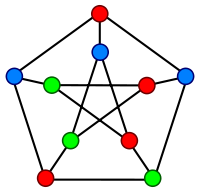

### 問題の作成

### Creating a problem

日本地図を扱うために Python の [japanmap](https://pypi.org/project/japanmap/) モジュールを使用します。都道府県コード ( $1 \sim{} 47$) を用いて都道府県名や隣接情報などを取得できます。

Use Python's [japanmap] (https://pypi.org/project/japanmap/) module to work with Japanese maps. You can use the prefecture code ($ 1 \sim{} 47 $) to get the prefecture name and adjacency information.



まずは色の定義を行い、変数テーブルを用意します。

First, define the color and prepare the variable table.

In [1]:
from amplify import BinaryPoly, gen_symbols
import japanmap as jm

colors = ["red", "green", "blue", "yellow"]
num_colors = len(colors)
num_region = len(jm.pref_names) - 1  # 都道府県数を取得 Obtained the number of prefectures

q = gen_symbols(BinaryPoly, num_region, num_colors)

In [2]:
q

[[q_0, q_1, q_2, q_3],
 [q_4, q_5, q_6, q_7],
 [q_8, q_9, q_10, q_11],
 [q_12, q_13, q_14, q_15],
 [q_16, q_17, q_18, q_19],
 [q_20, q_21, q_22, q_23],
 [q_24, q_25, q_26, q_27],
 [q_28, q_29, q_30, q_31],
 [q_32, q_33, q_34, q_35],
 [q_36, q_37, q_38, q_39],
 [q_40, q_41, q_42, q_43],
 [q_44, q_45, q_46, q_47],
 [q_48, q_49, q_50, q_51],
 [q_52, q_53, q_54, q_55],
 [q_56, q_57, q_58, q_59],
 [q_60, q_61, q_62, q_63],
 [q_64, q_65, q_66, q_67],
 [q_68, q_69, q_70, q_71],
 [q_72, q_73, q_74, q_75],
 [q_76, q_77, q_78, q_79],
 [q_80, q_81, q_82, q_83],
 [q_84, q_85, q_86, q_87],
 [q_88, q_89, q_90, q_91],
 [q_92, q_93, q_94, q_95],
 [q_96, q_97, q_98, q_99],
 [q_100, q_101, q_102, q_103],
 [q_104, q_105, q_106, q_107],
 [q_108, q_109, q_110, q_111],
 [q_112, q_113, q_114, q_115],
 [q_116, q_117, q_118, q_119],
 [q_120, q_121, q_122, q_123],
 [q_124, q_125, q_126, q_127],
 [q_128, q_129, q_130, q_131],
 [q_132, q_133, q_134, q_135],
 [q_136, q_137, q_138, q_139],
 [q_140, q_141, q_142, q_

#### Note

制約条件の多項式に現れる係数は全て整数なので、`amplify.BinaryPoly` の代わりに `amplify.BinaryIntPoly` を用いる事も可能です。


Since all the coefficients appearing in the constrained polynomial are integers, it is possible to use ʻamplify.BinaryIntPoly` instead of ʻamplify.BinaryPoly`.


次に制約条件を作成します。One-hot 制約は `amplify.constraint.equal_to` 関数、最小値0をとる制約については、 `amplify.constraint.penalty` 関数を用いて次のように書けます。


Next, create a constraint. One-hot constraints can be written using the ʻamplify.constraint.equal_to` function, and constraints with a minimum value of 0 can be written using the ʻamplify.constraint.penalty` function as follows.


In [3]:
from amplify import sum_poly
from amplify.constraint import equal_to, penalty

# 各領域に対する制約 
# Constraints for each area
reg_constraints = [
    equal_to(sum_poly([q[i][c] for c in range(num_colors)]), 1)
    for i in range(num_region)
]

# 隣接する領域間の制約
# Constraints between adjacent regions
adj_constraints = [
    # 都道府県コードと配列インデックスは1ずれてるので注意  
    # Please note that the prefecture code and the array index are off by one.
    penalty(q[i][c] * q[j - 1][c])
    for i in range(num_region)
    for j in jm.adjacent(i + 1)  # j: 隣接している都道府県コード  j: Adjacent prefecture code
    if i + 1 < j
    for c in range(num_colors)
]

constraints = sum(reg_constraints) + sum(adj_constraints)

隣接情報は `japanmap.adjacent` 関数に都道府県コードを入力すると隣接する都道府県コードを取得できます。`q` に対するインデックスと都道府県コードには $1$ だけ差分があるため注意してください。

Adjacent information can be obtained by entering the prefecture code in the `japanmap.adjacent` function. Note that there is a $ 1 $ difference between the index for `q` and the state code.


### Note

最小値 $0$ をとる制約条件については、先に全ての条件の和を取ってから単一の制約条件オブジェクトを作成しても等価です。隣接する領域間の制約について次のようにも書けます。


For constraints that take a minimum of $ 0 $, it is equivalent to first summing all the conditions and then creating a single constraint object. You can also write the constraints between adjacent regions as follows:

```python
# 隣接する領域間の制約
# Constraints between adjacent areas
adj_constraints = [
    # 都道府県コードと配列インデックスは1ずれてるので注意
    # Please note that the prefecture code and the array index are off by one.
    penalty(sum_poly(q[i][c] * q[j - 1][c]) for c in range(num_colors))
    for i in range(num_region)
    for j in jm.adjacent(i + 1)  # j: 隣接している都道府県コード  j: Adjacent prefecture code
    if i + 1 < j
]
```

以上で定式化に関する準備は完了です。


This completes the preparation for formulation.

### イジングマシンの実行


### Running the Ising machine

イジングマシンのクライアントを作成しパラメータを設定します。その後ソルバーを作成しクライアントを設定します。


Create a client for the Ising machine and set the parameters. Then create a solver and configure the client.

In [4]:
from amplify import Solver
from amplify.client import FixstarsClient

client = FixstarsClient()
client.url = "http://113.43.211.53:80"
client.parameters.timeout = 5000  # タイムアウト5秒 # Timeout 5 seconds

solver = Solver(client)

制約条件から論理模型を作成し、次のようにしてイジングマシンを実行し結果を取得します。

Create a logical model from the constraints, run the Ising machine as follows, and get the result.

In [5]:
from amplify import BinaryQuadraticModel

model = BinaryQuadraticModel(constraints)
print(model)
result = solver.solve(model)
if len(result.solutions) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

values = result.solutions[0].values

### Note

もし ``result.solutions`` オブジェクトが空のリストの場合、制約条件を満たす解が得られなかったことを意味します。この場合はイジングマシンのパラメータの変更が必要です。

If the `` results.solutions`` object is an empty list, it means that no solution was found that meets the constraints. In this case, it is necessary to change the parameters of the Ising machine.

### 結果の解析

### Result analysis

`values` は入力変数と解の値のマッピングを表す辞書です。そのままでは評価しづらいので、次のようにして変数テーブル `q` と同一の形式にデコードします。

`values` is a dictionary that represents the mapping between input variables and solution values. Since it is difficult to evaluate as it is, decode it to the same format as the variable table `q` as follows.


In [14]:
from amplify import decode_solution

q_values = decode_solution(q, values, 1)

結果を ``{都道府県名: 色}`` の形式に変換します。まずは ``q_values`` の各行のうち値が1のインデックスを取得します。次のように 
`numpy` の関数を使用します。その後、`japanmap.pref_names` を用いて都道府県名に変換し、対応する色を格納した辞書を作成します。


Converts the result to the format `` {prefecture name: color} ``. First, get the index with a value of 1 in each row of `` q_values``. as follows 
Use the function of `numpy`. After that, use `japanmap.pref_names` to convert it to a prefecture name and create a dictionary that stores the corresponding colors.


In [15]:
import numpy as np
color_indices = np.where(np.array(q_values) == 1)[1]
color_map = {jm.pref_names[i + 1]: colors[color_indices[i]] for i in range(len(color_indices))}

In [16]:
color_map

{'北海道': 'blue',
 '青森県': 'red',
 '岩手県': 'yellow',
 '宮城県': 'red',
 '秋田県': 'green',
 '山形県': 'yellow',
 '福島県': 'blue',
 '茨城県': 'green',
 '栃木県': 'yellow',
 '群馬県': 'green',
 '埼玉県': 'red',
 '千葉県': 'yellow',
 '東京都': 'blue',
 '神奈川県': 'yellow',
 '新潟県': 'red',
 '富山県': 'blue',
 '石川県': 'yellow',
 '福井県': 'blue',
 '山梨県': 'green',
 '長野県': 'yellow',
 '岐阜県': 'green',
 '静岡県': 'blue',
 '愛知県': 'red',
 '三重県': 'blue',
 '滋賀県': 'red',
 '京都府': 'yellow',
 '大阪府': 'red',
 '兵庫県': 'green',
 '奈良県': 'green',
 '和歌山県': 'yellow',
 '鳥取県': 'red',
 '島根県': 'green',
 '岡山県': 'blue',
 '広島県': 'yellow',
 '山口県': 'red',
 '徳島県': 'yellow',
 '香川県': 'green',
 '愛媛県': 'blue',
 '高知県': 'green',
 '福岡県': 'red',
 '佐賀県': 'green',
 '長崎県': 'blue',
 '熊本県': 'blue',
 '大分県': 'green',
 '宮崎県': 'red',
 '鹿児島県': 'yellow',
 '沖縄県': 'red'}

最後に得られた塗り分けを表示します。次のようにしてプロットされます。


The last obtained color is displayed. It is plotted as follows.

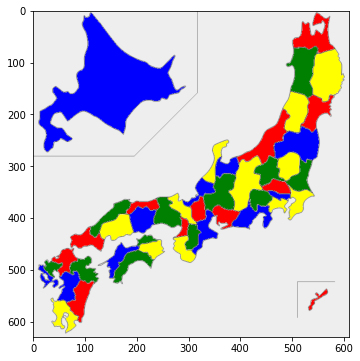

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 6, 6
plt.imshow(jm.picture(color_map))
plt.show()